### Практическая работа №4: Веб-скрейпинг с requests и BeautifulSoup
|   Группа          |   ФИО             |   
|   :------------:  |   :------------:  |
|   М092501(71)     |   Шарибжанов И.Т. |

**Задачи:**
1. Выбрать сайт с данными
2. Выгрузить данные с реальной страницы
3. Сохранить в pandas DataFrame (обязательно с числовыми столбцами для графиков)
4. Построить 5 разных видов графиков
5. Сохранить датафрейм в CSV-файл

**Выбранный сайт:** https://www.worldometers.info/world-population/population-by-country/  
**Данные:** Таблица численности населения по странам мира (на 2025)

**Описание полей данных:**
- **Country (or dependency)** — название страны или зависимой территории
- **Population 2025** — общая численность населения в 2025 году (человек)
- **Yearly Change** — годовой прирост населения в процентах (%)
- **Net Change** — абсолютное изменение численности населения за год (человек)
- **Density** — плотность населения (человек на км²)
- **Land Area (km²)** — площадь территории страны в квадратных километрах
- **Migrants (net)** — чистая миграция (разница между иммигрантами и эмигрантами, человек)
- **Fert.Rate** — суммарный коэффициент рождаемости (среднее число детей на одну женщину)
- **Median Age** — медианный возраст населения (лет)
- **Urban Pop** — доля городского населения в процентах (%)
- **World Share** — доля населения страны от общего населения мира (%)

#### 1. Импорт библиотек и выгрузка страницы

In [1]:
%pip install requests BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# URL страницы
URL = "https://www.worldometers.info/world-population/population-by-country/"

# Заголовки, чтобы сайт не блокировал запрос (имитируем браузер)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36"
}

# Получаем страницу
response = requests.get(URL, headers=headers)
response.raise_for_status()  # на случай ошибки

# Парсим HTML
soup = BeautifulSoup(response.text, "html.parser")

#### 2. Парсинг таблицы

In [3]:
# Находим таблицу
table = soup.find("table")

# Извлекаем заголовки
thead = table.find("thead")
headers = [th.get_text(strip=True) for th in thead.find_all("th")]

# Извлекаем все строки тела таблицы
tbody = table.find("tbody")
rows = []

for tr in tbody.find_all("tr"):
    cells = tr.find_all("td")
    
    row = []
    for td in cells:
        # Для колонки со страной берём только текст ссылки (чистое название страны)
        a_tag = td.find("a")
        if a_tag:
            row.append(a_tag.get_text(strip=True))
        else:
            # Для остальных колонок берём видимый текст
            text = td.get_text(strip=True)
            row.append(text)
    
    rows.append(row)    

#### 3. Сохранение в pandas DataFrame

In [4]:
df_raw = pd.DataFrame(rows, columns=headers)
df_raw.head()

,#,Country (or dependency),Population 2025,Yearly Change,Net Change,Density (P/KmÂ²),Land Area (KmÂ²),Migrants (net),Fert. Rate,Median Age,Urban Pop %,World Share
0,1,India,"1,463,865,525",0.89%,"12,929,734",492,"2,973,190","â495,753",1.94,28.8,37.1%,17.78%
1,2,China,"1,416,096,094",â0.23%,"â3,225,184",151,"9,388,211","â268,126",1.02,40.1,67.5%,17.20%
2,3,United States,"347,275,807",0.54%,"1,849,236",38,"9,147,420","1,230,663",1.62,38.5,82.8%,4.22%
3,4,Indonesia,"285,721,236",0.79%,"2,233,305",158,"1,811,570","â39,509",2.1,30.4,59.6%,3.47%
4,5,Pakistan,"255,219,554",1.57%,"3,950,390",331,"770,880","â1,235,336",3.5,20.6,34.4%,3.10%


In [5]:
# Функция для очистки строки перед конвертацией
def clean_number(x):
    if pd.isna(x):
        return np.nan
    # Приводим к строке и чистим
    s = str(x).strip()
    # Убираем неразрывные пробелы и проблемные символы
    s = s.replace('\xa0', '').replace('\u2212', '-').replace('â', '-')
    # Убираем запятые как разделители тысяч
    s = s.replace(',', '')
    # Убираем % в конце (но только если это действительно процент)
    if s.endswith('%'):
        s = s[:-1]
        try:
            return float(s) / 100  # возвращаем как долю (например 37.1% → 0.371)
        except:
            return np.nan
    # Обычное число
    try:
        if '.' in s or 'e' in s.lower():
            return float(s)
        else:
            return int(s)
    except:
        return np.nan

In [6]:
df_clean = df_raw.copy()

for col in df_clean.columns[2:]:  # пропускаем "#" и "Country (or dependency)"
    df_clean[col] = df_clean[col].apply(lambda x: clean_number(x) * 100 if isinstance(clean_number(x), float) and str(x).endswith('%') else clean_number(x))

df_clean.head()

,#,Country (or dependency),Population 2025,Yearly Change,Net Change,Density (P/KmÂ²),Land Area (KmÂ²),Migrants (net),Fert. Rate,Median Age,Urban Pop %,World Share
0,1,India,1463865525,0.89,12929734,492,2973190,-495753,1.94,28.8,37.1,17.78
1,2,China,1416096094,-0.23,-3225184,151,9388211,-268126,1.02,40.1,67.5,17.20
2,3,United States,347275807,0.54,1849236,38,9147420,1230663,1.62,38.5,82.8,4.22
3,4,Indonesia,285721236,0.79,2233305,158,1811570,-39509,2.10,30.4,59.6,3.47
4,5,Pakistan,255219554,1.57,3950390,331,770880,-1235336,3.50,20.6,34.4,3.10


#### 4. Построение графиков

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['font.size'] = 12

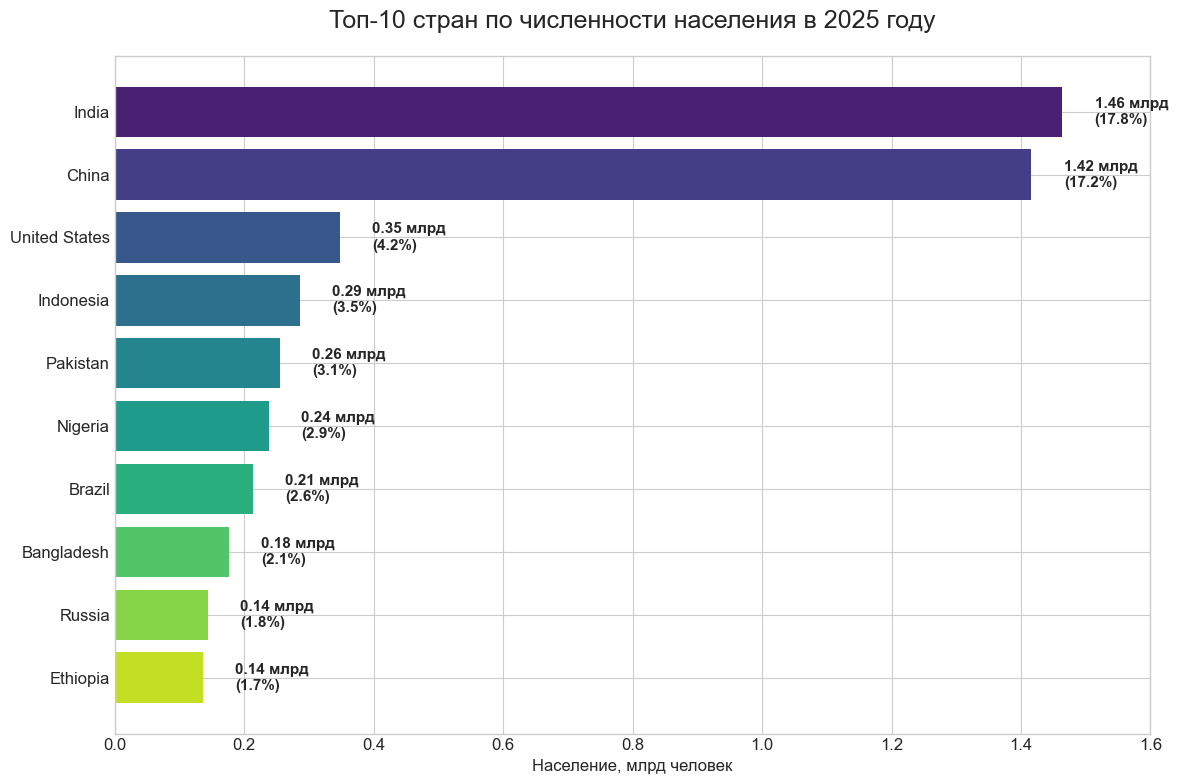

In [8]:
# 1. Топ-10 стран по численности населения + доля в мире (горизонтальный барплот)
top10 = df_clean.nlargest(10, 'Population 2025').copy()
top10['population_billion'] = top10['Population 2025'] / 1e9

plt.figure(figsize=(12, 8))
bars = plt.barh(top10['Country (or dependency)'][::-1], top10['population_billion'][::-1], color=sns.color_palette("viridis", 10)[::-1])

# Подписываем точные значения
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
             f"{top10['population_billion'].iloc[-(i+1)]:.2f} млрд\n({top10['World Share'].iloc[-(i+1)]:.1f}%)",
             va='center', ha='left', fontweight='bold', fontsize=11)

plt.title('Топ-10 стран по численности населения в 2025 году', fontsize=18, pad=20)
plt.xlabel('Население, млрд человек')
plt.ylabel('')
plt.xlim(0, 1.6)
plt.tight_layout()
plt.show()

**Анализ графика**

График демонстрирует распределение населения среди крупнейших стран мира в 2025 году. Основные выводы:

1. **Абсолютное лидерство Китая и Индии**: Две азиатские страны значительно опережают остальные — на их долю приходится более 35% мирового населения. Индия (около 1.4 млрд) и Китай (около 1.4 млрд) вместе составляют почти треть населения планеты.

2. **Высокая концентрация населения**: Топ-10 стран концентрируют более 60% мирового населения, что указывает на значительную географическую неравномерность распределения людей по планете.

3. **Региональное распределение**: 
   - Азия доминирует (Китай, Индия, Индонезия, Пакистан, Бангладеш, Филиппины)
   - Северная и Южная Америка представлены США и Бразилией
   - Африка представлена Нигерией и ДР Конго
   - Европа отсутствует в топ-10, что отражает демографический спад в регионе

4. **Демографические тенденции**: Наличие развивающихся стран (Нигерия, ДР Конго, Пакистан) в топ-10 указывает на продолжающийся демографический рост в Африке и Южной Азии, в то время как развитые страны (США, Бразилия) имеют более стабильную динамику.


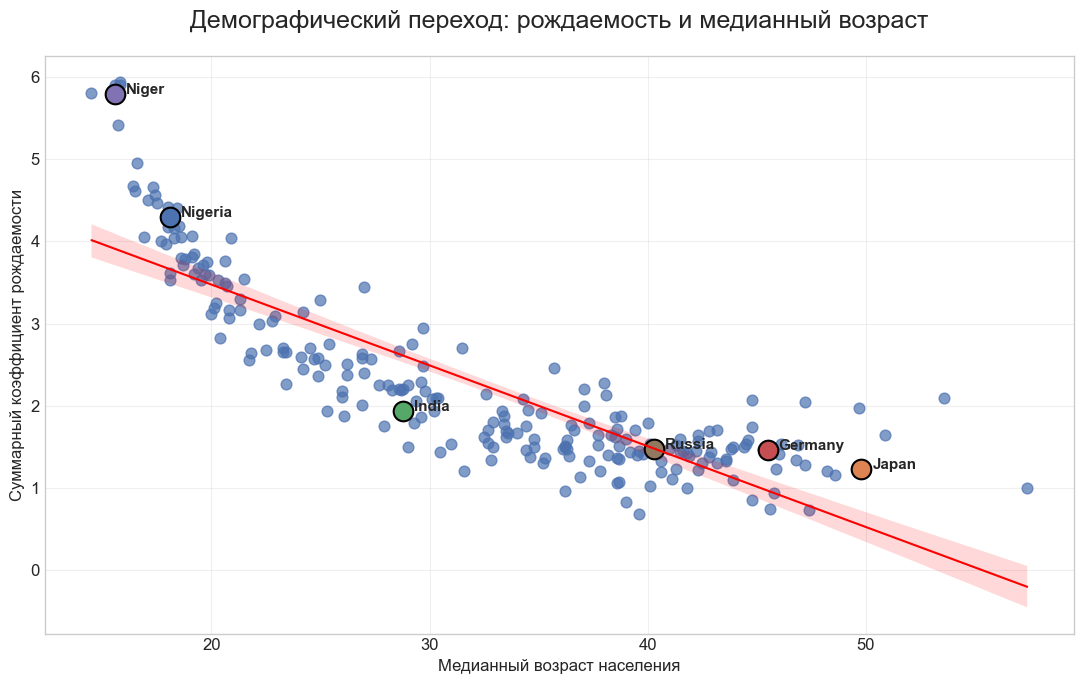

In [9]:
# 2. Зависимость рождаемости от медианного возраста (с линией тренда)
plt.figure(figsize=(11, 7))
sns.regplot(
    data=df_clean, x='Median Age', y='Fert. Rate',
    scatter_kws={'alpha': 0.7, 's': 60},
    line_kws={'color': 'red', 'linewidth': 1.5}
)

# Подсвечиваем ключевые страны
highlight = ['Nigeria', 'Japan', 'India', 'Germany', 'Niger', 'Russia']
for country in highlight:
    row = df_clean[df_clean['Country (or dependency)'] == country]
    if not row.empty:
        plt.scatter(row['Median Age'], row['Fert. Rate'], s=200, edgecolors='black', linewidth=1.5)
        plt.text(row['Median Age'].iloc[0] + 0.5, row['Fert. Rate'].iloc[0], country, fontsize=11, fontweight='bold')

plt.title('Демографический переход: рождаемость и медианный возраст', fontsize=18, pad=20)
plt.xlabel('Медианный возраст населения')
plt.ylabel('Суммарный коэффициент рождаемости')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Анализ графика**

График демонстрирует классическую обратную зависимость между медианным возрастом населения и коэффициентом рождаемости, что является ключевым индикатором демографического перехода. Основные выводы:

1. **Отрицательная корреляция**: Чётко выраженная нисходящая линия тренда показывает, что с увеличением медианного возраста населения рождаемость снижается. Это отражает универсальный процесс демографического перехода от традиционного к современному типу воспроизводства населения.

2. **Демографические полюса**:
   - **Молодые страны с высокой рождаемостью** (Niger, Nigeria): низкий медианный возраст (15-20 лет) и высокая рождаемость (5-7 детей на женщину) — характерно для ранней стадии демографического перехода
   - **Стареющие страны с низкой рождаемостью** (Japan, Germany): высокий медианный возраст (45-50 лет) и низкая рождаемость (1.3-1.5 детей на женщину) — завершённый демографический переход

3. **Промежуточные позиции**:
   - **India**: находится в середине перехода — медианный возраст около 28-30 лет, рождаемость около 2.0-2.2
   - **Russia**: демонстрирует признаки старения населения с относительно низкой рождаемостью

4. **Социально-экономические факторы**: Страны с более высоким уровнем развития (образование женщин, доступ к контрацепции, урбанизация) имеют более низкую рождаемость и более высокий медианный возраст, что подтверждает теорию демографического перехода.


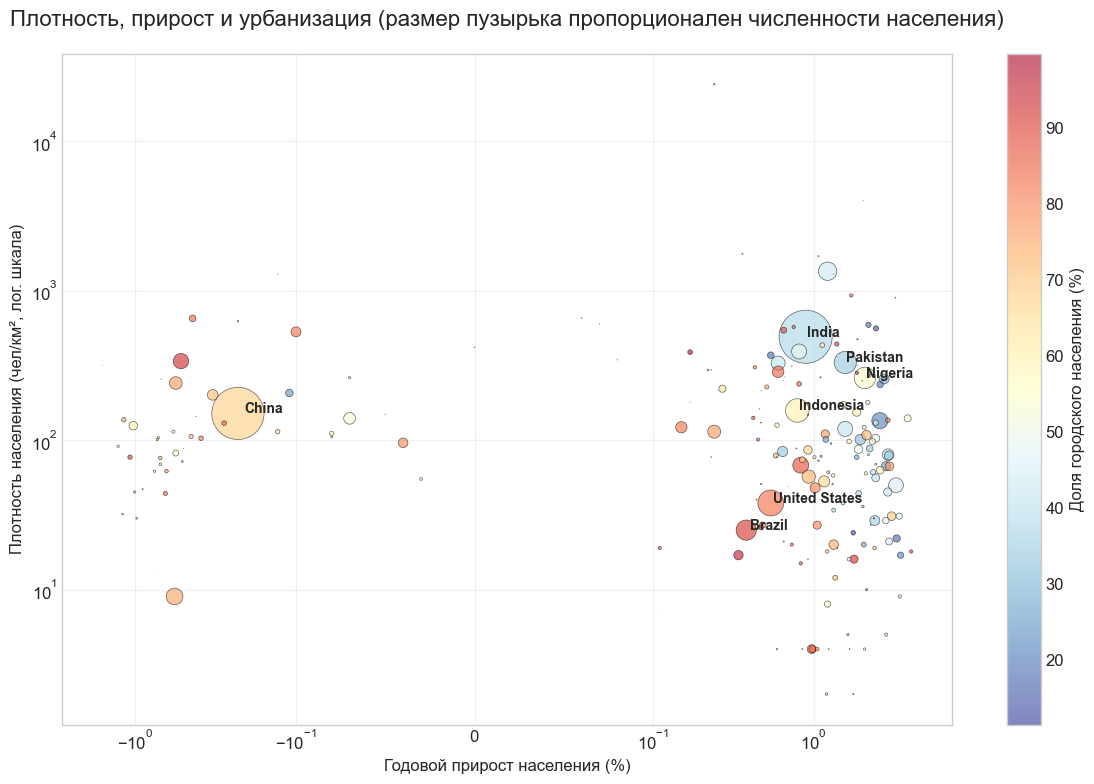

In [10]:
# 3. Плотность населения и годовой прирост (с размером пузырьков = численность населения)
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    df_clean['Yearly Change'], df_clean['Density (P/KmÂ²)'],
    s=df_clean['Population 2025'] / 1e6,  # размер пузырька пропорционален населению
    alpha=0.6, c=df_clean['Urban Pop %'], cmap='RdYlBu_r', edgecolors='black', linewidth=0.5
)

# Подписываем крупнейшие страны
big_countries = df_clean[df_clean['Population 2025'] > 200_000_000]
for _, row in big_countries.iterrows():
    plt.text(row['Yearly Change'] + 0.02, row['Density (P/KmÂ²)'], row['Country (or dependency)'], fontsize=10, fontweight='bold')

plt.colorbar(scatter, label='Доля городского населения (%)')
plt.xscale('symlog', linthresh=0.1)  # чтобы хорошо видеть и отрицательный рост
plt.yscale('log')
plt.xlabel('Годовой прирост населения (%)')
plt.ylabel('Плотность населения (чел/км², лог. шкала)')
plt.title('Плотность, прирост и урбанизация (размер пузырька пропорционален численности населения)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Анализ графика**

График представляет многомерный анализ демографических показателей, где одновременно отображаются плотность населения, годовой прирост, численность населения (размер пузырьков) и уровень урбанизации (цвет).

1. **Отсутствие прямой связи между плотностью и приростом**: График показывает, что высокая плотность населения не обязательно коррелирует с высоким приростом. Страны с очень высокой плотностью (например, Бангладеш, более 1000 чел/км²) могут иметь умеренный прирост, в то время как страны с низкой плотностью могут демонстрировать высокий прирост (например, африканские страны).

2. **Влияние урбанизации** (цветовая шкала):
   - Страны с высокой урбанизацией (красные/жёлтые оттенки) обычно имеют более низкий прирост населения
   - Страны с низкой урбанизацией (синие оттенки) часто демонстрируют более высокий прирост
   - Это подтверждает связь между урбанизацией и снижением рождаемости

3. **Крупнейшие страны** (большие пузырьки):
   - Китай и Индия выделяются размерами, но находятся в разных позициях по приросту
   - США демонстрируют умеренную плотность и низкий прирост при высокой урбанизации
   - Бразилия показывает средние показатели по всем параметрам


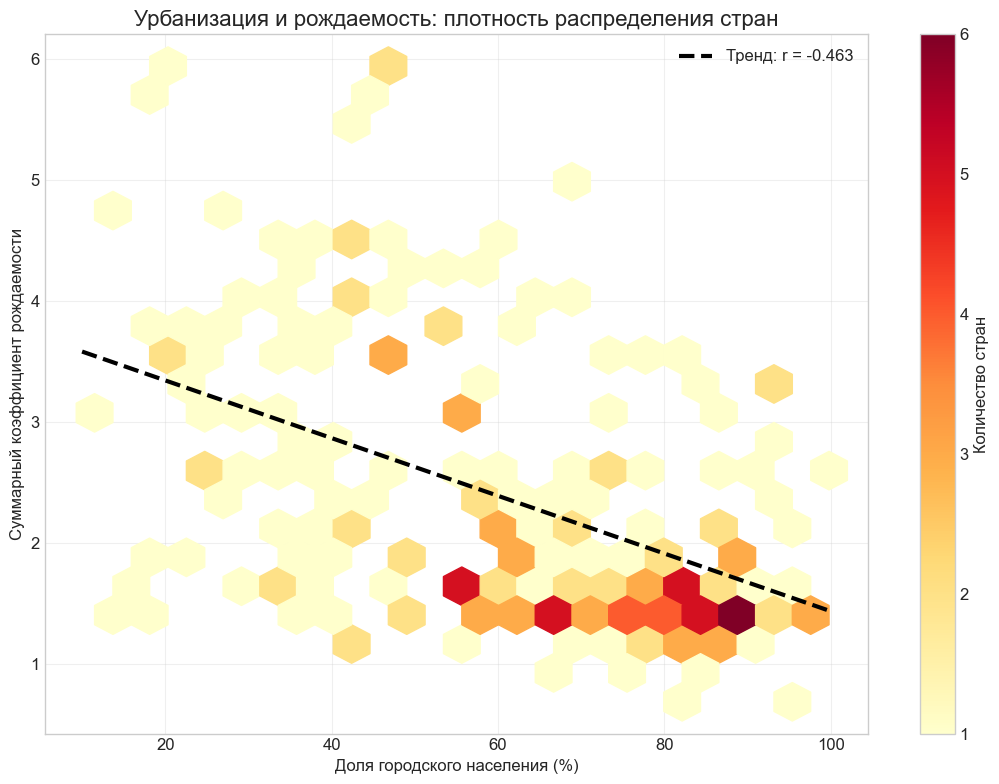

In [11]:
# 4. Распределение стран по уровню урбанизации и рождаемости (heatmap / hexbin)
data = df_clean.dropna(subset=["Urban Pop %", "Fert. Rate"])

plt.figure(figsize=(11, 8))
hb = plt.hexbin(data["Urban Pop %"], data["Fert. Rate"], gridsize=20, cmap="YlOrRd", mincnt=1)

plt.colorbar(hb, label="Количество стран")
plt.xlabel("Доля городского населения (%)")
plt.ylabel("Суммарный коэффициент рождаемости")
plt.title("Урбанизация и рождаемость: плотность распределения стран", fontsize=16)

# Линия тренда
z = np.polyfit(data["Urban Pop %"], data["Fert. Rate"], 1)
p = np.poly1d(z)
x_line = np.linspace(10, 100, 100)
plt.plot(x_line, p(x_line), color="black", linewidth=3, linestyle="--",
         label=f"Тренд: r = {np.corrcoef(data['Urban Pop %'], data['Fert. Rate'])[0,1]:.3f}")
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Анализ графика**

График использует метод hexbin для визуализации плотности распределения стран в пространстве урбанизации и рождаемости, что позволяет выявить кластеры и общие закономерности.

1. **Сильная отрицательная корреляция**: Линия тренда с коэффициентом корреляции (r) показывает чёткую обратную зависимость между уровнем урбанизации и рождаемостью. Чем выше доля городского населения, тем ниже коэффициент рождаемости. Это подтверждает теорию демографического перехода.

2. **Интенсивность цвета hexbin**: Более тёмные/яркие области (жёлто-оранжево-красные) показывают зоны с наибольшей концентрацией стран, что помогает понять, какие комбинации урбанизации и рождаемости наиболее типичны в мире.

3. **Демографический переход в действии**: График наглядно показывает процесс перехода стран от традиционного типа воспроизводства (низкая урбанизация, высокая рождаемость) к современному (высокая урбанизация, низкая рождаемость), причём большинство стран находится на разных стадиях этого перехода.


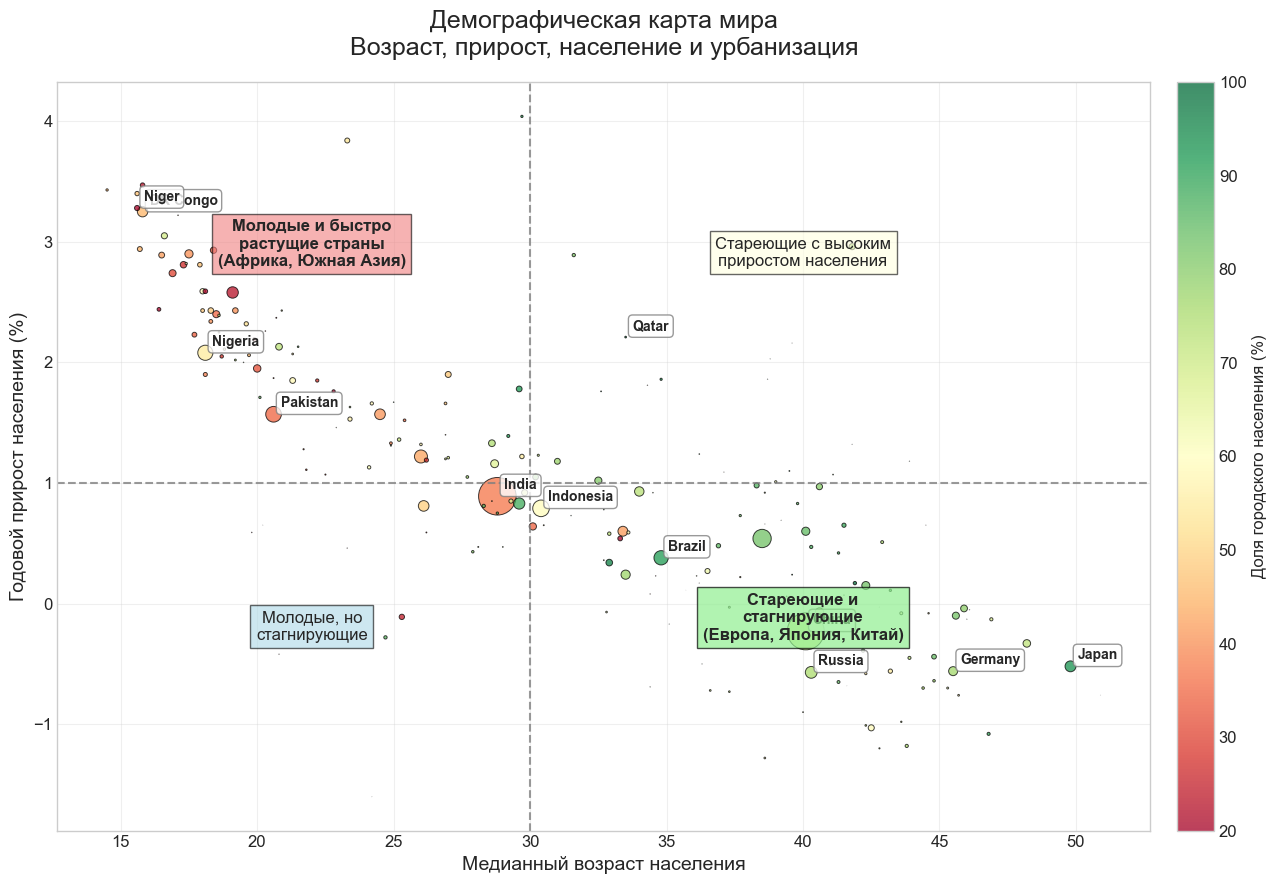

In [12]:
# 5. Демографическая карта мира: возраст, прирост, население и урбанизация
data = df_clean.dropna(subset=["Median Age", "Yearly Change", "Population 2025", "Urban Pop %"]).copy()

plt.figure(figsize=(14, 9))

scatter = plt.scatter(
    data["Median Age"],
    data["Yearly Change"],
    s=data["Population 2025"] / 2e6,           # размер пузыря — население
    c=data["Urban Pop %"],                # цвет — урбанизация
    cmap="RdYlGn",
    alpha=0.75,
    edgecolors="black",
    linewidth=0.7
)

plt.colorbar(scatter, label="Доля городского населения (%)", pad=0.02)
plt.clim(20, 100)  # чтобы цветовая шкала была читаемой

# Подписываем ключевые страны
highlight_countries = ["India", "China", "Nigeria", "Japan", "Germany", "Brazil", "Russia", 
                      "Pakistan", "Indonesia", "DR Congo", "Niger", "Qatar", "Singapore"]

for _, row in data[data["Country (or dependency)"].isin(highlight_countries)].iterrows():
    plt.annotate(row["Country (or dependency)"], 
                 (row["Median Age"], row["Yearly Change"]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold', 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="gray"))

# Вертикальная и горизонтальная линии для разделения квадрантов
plt.axvline(30, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

# Подписи квадрантов
plt.text(22, 2.8, "Молодые и быстро\nрастущие страны\n(Африка, Южная Азия)", ha='center', fontsize=12, fontweight='bold', bbox=dict(facecolor='lightcoral', alpha=0.6))
plt.text(40, 2.8, "Стареющие с высоким\nприростом населения", ha='center', fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.6))
plt.text(22, -0.3, "Молодые, но\nстагнирующие", ha='center', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.6))
plt.text(40, -0.3, "Стареющие и\nстагнирующие\n(Европа, Япония, Китай)", ha='center', fontsize=12, fontweight='bold', bbox=dict(facecolor='lightgreen', alpha=0.7))

plt.xlabel("Медианный возраст населения", fontsize=14)
plt.ylabel("Годовой прирост населения (%)", fontsize=14)
plt.title("Демографическая карта мира\nВозраст, прирост, население и урбанизация", fontsize=18, pad=20)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Анализ графика**

График представляет комплексную демографическую классификацию стран мира, объединяя четыре ключевых показателя в единую визуализацию с разделением на квадранты. Основные выводы:

1. **Квадрантная структура демографических типов**:
   - **Квадрант I (левый верхний) — "Молодые и быстро растущие"**: Страны с низким медианным возрастом (<30 лет) и высоким приростом (>1%). Здесь сосредоточено большинство африканских стран (Niger, Nigeria, DR Congo) и некоторые азиатские (Pakistan). Характерны высокая рождаемость и низкая урбанизация (красные/жёлтые оттенки).
   - **Квадрант II (правый верхний) — "Стареющие с высоким приростом"**: Редкая категория — страны с высоким медианным возрастом (>30 лет), но всё ещё растущим населением. Могут включать страны с иммиграцией или временными демографическими особенностями.
   - **Квадрант III (левый нижний) — "Молодые, но стагнирующие"**: Страны с молодым населением, но низким или отрицательным приростом. Причины стагнации могут быть связаны с экономическими кризисами, эмиграцией или особыми социальными условиями.
   - **Квадрант IV (правый нижний) — "Стареющие и стагнирующие"**: Развитые страны с высоким медианным возрастом (>30 лет) и низким/отрицательным приростом. Типичные представители: Japan, Germany, большинство европейских стран, а также China (из-за политики одного ребёнка). Высокая урбанизация (зеленые оттенки).

2. **Многомерная визуализация**:
   - **Размер пузырьков** отражает численность населения — крупнейшие страны (China, India, USA) выделяются размерами
   - **Цвет пузырьков** показывает уровень урбанизации — от красного (низкая урбанизация) до зеленого (высокая урбанизация)
   - **Позиция на графике** определяет демографический тип страны

3. **Глобальные демографические тренды**:
   - Большинство стран мира находится в квадранте I (быстро растущие молодые страны) или квадранте IV (стареющие развитые страны)
   - Квадранты II и III содержат меньше стран, что указывает на редкость таких комбинаций показателей
   - Наблюдается глобальный переход стран из квадранта I в квадрант IV по мере экономического развития


#### 5. Сохранение датафрейма в CSV формате

In [13]:
df_clean.to_csv('world_population_nov_2025.csv', index=False, encoding='utf-8-sig')

#### Бонус

In [14]:
import plotly.express as px

fig = px.scatter(
    df_clean,
    x="Median Age",
    y="Yearly Change",
    size="Population 2025",                    # размер пузыря = население
    color="Urban Pop %",         # цвет = урбанизация
    hover_name="Country (or dependency)",                 # при наведении — название страны
    hover_data={
        "Population 2025": ":,.0f",
        "Fert. Rate": ":.2f",
        "Density (P/KmÂ²)": ":,.0f",
        "World Share": ":.2f",
        "Median Age": ":.1f",
        "Yearly Change": ":.2f",
        "Urban Pop %": ":.1f"
    },
    size_max=70,
    color_continuous_scale="Viridis",
    range_x=[15, 55],
    range_y=[-1, 3.5],
    labels={
        "Median Age": "Медианный возраст",
        "Yearly Change": "Годовой прирост населения (%)",
        "Urban Pop %": "Городское население (%)",
        "Population 2025": "Население"
    },
    title="<b>Демографическая карта мира 2025</b><br><sup>Наведи мышку — увидишь все данные по стране</sup>"
)

# Добавляем линии разделения
fig.add_hline(y=1.0, line_dash="dash", line_color="gray", opacity=0.7)
fig.add_vline(x=30, line_dash="dash", line_color="gray", opacity=0.7)

# Подписи квадрантов
fig.add_annotation(x=22, y=2.8, text="Молодые и быстро растущие<br>(Африка, Южная Азия)", showarrow=False,
                   font=dict(size=12, color="darkred"), bgcolor="rgba(255,200,200,0.6)", borderpad=8)
fig.add_annotation(x=42, y=2.8, text="Стареющие с высоким приростом", showarrow=False,
                   font=dict(size=11), bgcolor="rgba(255,255,200,0.6)", borderpad=6)
fig.add_annotation(x=22, y=-0.3, text="Молодые, но стагнирующие", showarrow=False,
                   font=dict(size=11), bgcolor="rgba(200,220,255,0.6)", borderpad=6)
fig.add_annotation(x=42, y=-0.3, text="Стареющие и стагнирующие<br>(Европа, Япония, Китай)", showarrow=False,
                   font=dict(size=12, color="darkgreen"), bgcolor="rgba(200,255,200,0.8)", borderpad=8)

fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    width=1100,
    height=700,
    font=dict(family="Arial", size=13),
    legend_title_text="Городское население (%)"
)

# Показываем
fig.show()
# Сохраняем в HTML
fig.write_html("demographic_world_2025_interactive.html")